# test_lens_fundamental_plane

基于 `db_zBEAMS_PEMD_100000_s1_GDB_phot_err_ManySF_TL.csv` 的 lens fundamental-plane 探针：
- 输入使用 `zL_true`, `zS_true`, `tE_true`, `veldisp_true`，并将 `veldisp_true` 线性映射为 `Re_true`（0.5-2.8 arcsec）
- `gamma` 不作为观测量，仅由 parent population 抽样
- 运行 clean/noisy 两套 HMC，输出 divergence、trace、corner overlay

In [14]:
import os
os.environ.setdefault('HDF5_USE_FILE_LOCKING', 'FALSE')

from pathlib import Path
import sys

workdir = Path.cwd()
if (workdir / 'hmc_scripts').exists() is False:
    workdir = Path('/users/tianli/LensedUniverse')
os.chdir(workdir)
if str(workdir) not in sys.path:
    sys.path.insert(0, str(workdir))

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax import random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import NUTS, MCMC, init_to_value
import arviz as az

from slcosmo import tool
from hmc_scripts.corner_utils import select_corner_vars, make_overlay_corner

USE_X64 = os.environ.get("SLCOSMO_USE_X64", "0").strip().lower() in {"1", "true", "yes", "y", "on"}
jax.config.update("jax_enable_x64", USE_X64)
if USE_X64:
    numpyro.enable_x64()
if any(d.platform == "gpu" for d in jax.devices()):
    numpyro.set_platform("gpu")
else:
    numpyro.set_platform("cpu")
print("Precision mode:", "FP64" if USE_X64 else "FP32")

SEED = 42
rng_np = np.random.default_rng(SEED)
np.random.seed(SEED)

TEST_MODE = False
RESULT_DIR = Path('/mnt/lustre/tianli/LensedUniverse_result')
RESULT_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR = Path('result')
FIG_DIR.mkdir(parents=True, exist_ok=True)

DATA_DIR = Path(os.environ.get('SLCOSMO_DATA_DIR', str(workdir / 'data')))
DATA_CSV = DATA_DIR / 'db_zBEAMS_PEMD_100000_s1_GDB_phot_err_ManySF_TL.csv'

Precision mode: FP32


In [16]:
cosmo_true = {'Omegam': 0.32, 'Omegak': 0.0, 'w0': -1.0, 'wa': 0.0, 'h0': 70.0}
cosmo_prior = {
    'w0_up': 0.0, 'w0_low': -2.0,
    'wa_up': 2.0, 'wa_low': -2.0,
    'omegak_up': 1.0, 'omegak_low': -1.0,
    'h0_up': 80.0, 'h0_low': 60.0,
    'omegam_up': 0.5, 'omegam_low': 0.1,
}

Z_SIGMA_CLIP = 2.0
VEL_FRAC_ERR_MAX = 0.30

LUT = np.load(DATA_DIR / 'velocity_disp_table.npy')
N1, N2, N3, N4 = LUT.shape
thetaE_grid = np.linspace(0.5, 3.0, N1)
gamma_grid = np.linspace(1.2, 2.8, N2)
Re_grid = np.linspace(0.15, 3.0, N3)
beta_grid = np.linspace(-0.5, 0.8, N4)
jampy_interp = tool.make_4d_interpolant(thetaE_grid, gamma_grid, Re_grid, beta_grid, LUT)

fp_df = pd.read_csv(DATA_CSV)
if TEST_MODE:
    n_use_target = 200
else:
    n_use_target = 20000
print('Loaded FP systems before observation cuts:', fp_df.shape[0])
zl_fp = fp_df['zL_true'].to_numpy()
zs_fp = fp_df['zS_true'].to_numpy()
zL_sigma_fp = np.abs(fp_df['sigma_zL_obs'].to_numpy())
zS_sigma_fp = np.abs(fp_df['sigma_zS_obs'].to_numpy())
thetaE_true_fp = fp_df['tE_true'].to_numpy()
veldisp_true_catalog = fp_df['veldisp_true'].to_numpy()
vel_frac_err_template = fp_df['sigma_veldisp_obs'].to_numpy() / veldisp_true_catalog
vel_min = np.min(veldisp_true_catalog)
vel_max = np.max(veldisp_true_catalog)
re_fp = 0.5 + (veldisp_true_catalog - vel_min) * (2.8 - 0.5) / (vel_max - vel_min)

print(
    'Re_true from linear veldisp mapping:'
    f' vmin={vel_min:.3f}, vmax={vel_max:.3f}, min={re_fp.min():.4f}, median={np.median(re_fp):.4f}, max={re_fp.max():.4f}'
)
theta_keep_mask = thetaE_true_fp <= 2.5
print('After thetaE_true<=2.5 cut:', int(theta_keep_mask.sum()), '/', theta_keep_mask.size)
zl_fp = zl_fp[theta_keep_mask]
zs_fp = zs_fp[theta_keep_mask]
zL_sigma_fp = zL_sigma_fp[theta_keep_mask]
zS_sigma_fp = zS_sigma_fp[theta_keep_mask]
thetaE_true_fp = thetaE_true_fp[theta_keep_mask]
re_fp = re_fp[theta_keep_mask]
veldisp_true_catalog = veldisp_true_catalog[theta_keep_mask]
vel_frac_err_template = vel_frac_err_template[theta_keep_mask]
thetaE_err_fp = 0.01 * thetaE_true_fp

vel_err_keep_mask = vel_frac_err_template < VEL_FRAC_ERR_MAX
print(
    f'After frac vel err<{VEL_FRAC_ERR_MAX:.2f} cut:',
    int(vel_err_keep_mask.sum()),
    '/',
    vel_err_keep_mask.size,
)
zl_fp = zl_fp[vel_err_keep_mask]
zs_fp = zs_fp[vel_err_keep_mask]
zL_sigma_fp = zL_sigma_fp[vel_err_keep_mask]
zS_sigma_fp = zS_sigma_fp[vel_err_keep_mask]
thetaE_true_fp = thetaE_true_fp[vel_err_keep_mask]
thetaE_err_fp = thetaE_err_fp[vel_err_keep_mask]
re_fp = re_fp[vel_err_keep_mask]
veldisp_true_catalog = veldisp_true_catalog[vel_err_keep_mask]
vel_frac_err_template = vel_frac_err_template[vel_err_keep_mask]

_dl_fp_true, ds_fp_true, dls_fp_true = tool.dldsdls(zl_fp, zs_fp, cosmo_true, n=20)
gamma_true_fp = tool.truncated_normal(2.0, 0.2, 1.5, 2.5, zl_fp.size, random_state=rng_np)
beta_true_fp = tool.truncated_normal(0.0, 0.2, -0.4, 0.4, zl_fp.size, random_state=rng_np)
lambda_true_fp = tool.truncated_normal(1.0, 0.05, 0.8, 1.2, zl_fp.size, random_state=rng_np)
vel_model_fp = jampy_interp(thetaE_true_fp, gamma_true_fp, re_fp, beta_true_fp) * jnp.sqrt(ds_fp_true / dls_fp_true)
vel_true_fp = np.asarray(vel_model_fp) * np.sqrt(lambda_true_fp)
vel_err_fp = vel_frac_err_template * np.abs(vel_true_fp)

clean_keep_mask = vel_true_fp <= 400.0
print('After clean vel<=400 cut:', int(clean_keep_mask.sum()), '/', clean_keep_mask.size)
zl_fp = zl_fp[clean_keep_mask]
zs_fp = zs_fp[clean_keep_mask]
zL_sigma_fp = zL_sigma_fp[clean_keep_mask]
zS_sigma_fp = zS_sigma_fp[clean_keep_mask]
thetaE_true_fp = thetaE_true_fp[clean_keep_mask]
thetaE_err_fp = thetaE_err_fp[clean_keep_mask]
re_fp = re_fp[clean_keep_mask]
gamma_true_fp = gamma_true_fp[clean_keep_mask]
beta_true_fp = beta_true_fp[clean_keep_mask]
lambda_true_fp = lambda_true_fp[clean_keep_mask]
vel_true_fp = vel_true_fp[clean_keep_mask]
vel_err_fp = vel_err_fp[clean_keep_mask]

thetaE_obs_clean_fp = thetaE_true_fp.copy()
vel_obs_clean_fp = vel_true_fp.copy()
vel_q = np.quantile(vel_obs_clean_fp, [0.01, 0.05, 0.50, 0.95, 0.99])
print(
    'vel_obs_clean_fp stats before noisy cuts:'
    f' min={vel_obs_clean_fp.min():.3f}, q01={vel_q[0]:.3f}, q05={vel_q[1]:.3f},'
    f' median={vel_q[2]:.3f}, q95={vel_q[3]:.3f}, q99={vel_q[4]:.3f}, max={vel_obs_clean_fp.max():.3f}'
)

thetaE_obs_noisy_fp = thetaE_true_fp + rng_np.normal(0.0, thetaE_err_fp)
vel_obs_noisy_fp = tool.truncated_normal(vel_true_fp, vel_err_fp, 100.0, 500.0, random_state=rng_np)
noisy_keep_mask = vel_obs_noisy_fp <= 400.0
print('After noisy vel<=400 cut:', int(noisy_keep_mask.sum()), '/', noisy_keep_mask.size)

zl_fp = zl_fp[noisy_keep_mask]
zs_fp = zs_fp[noisy_keep_mask]
zL_sigma_fp = zL_sigma_fp[noisy_keep_mask]
zS_sigma_fp = zS_sigma_fp[noisy_keep_mask]
thetaE_true_fp = thetaE_true_fp[noisy_keep_mask]
thetaE_err_fp = thetaE_err_fp[noisy_keep_mask]
re_fp = re_fp[noisy_keep_mask]
gamma_true_fp = gamma_true_fp[noisy_keep_mask]
beta_true_fp = beta_true_fp[noisy_keep_mask]
lambda_true_fp = lambda_true_fp[noisy_keep_mask]
vel_err_fp = vel_err_fp[noisy_keep_mask]
thetaE_obs_clean_fp = thetaE_obs_clean_fp[noisy_keep_mask]
vel_obs_clean_fp = vel_obs_clean_fp[noisy_keep_mask]
thetaE_obs_noisy_fp = thetaE_obs_noisy_fp[noisy_keep_mask]
vel_obs_noisy_fp = vel_obs_noisy_fp[noisy_keep_mask]

zL_low_fp = zl_fp - Z_SIGMA_CLIP * zL_sigma_fp
zL_high_fp = zl_fp + Z_SIGMA_CLIP * zL_sigma_fp
zS_low_fp = zs_fp - Z_SIGMA_CLIP * zS_sigma_fp
zS_high_fp = zs_fp + Z_SIGMA_CLIP * zS_sigma_fp

z_lower_pos_mask = (zL_low_fp > 0.0) & (zS_low_fp > 0.0)
z_sep_sigma_mask = (zs_fp - zl_fp) > (Z_SIGMA_CLIP * zS_sigma_fp + Z_SIGMA_CLIP * zL_sigma_fp)
z_bounds_disjoint_mask = zS_low_fp > zL_high_fp
z_prior_mask = z_lower_pos_mask & z_sep_sigma_mask & z_bounds_disjoint_mask
print(
    'After z-bound cut (z_low>0 and zs-zl>2sigma_zs+2sigma_zl):',
    int(z_prior_mask.sum()),
    '/',
    z_prior_mask.size,
)
zl_fp = zl_fp[z_prior_mask]
zs_fp = zs_fp[z_prior_mask]
zL_sigma_fp = zL_sigma_fp[z_prior_mask]
zS_sigma_fp = zS_sigma_fp[z_prior_mask]
zL_low_fp = zL_low_fp[z_prior_mask]
zL_high_fp = zL_high_fp[z_prior_mask]
zS_low_fp = zS_low_fp[z_prior_mask]
zS_high_fp = zS_high_fp[z_prior_mask]
thetaE_true_fp = thetaE_true_fp[z_prior_mask]
thetaE_err_fp = thetaE_err_fp[z_prior_mask]
re_fp = re_fp[z_prior_mask]
gamma_true_fp = gamma_true_fp[z_prior_mask]
beta_true_fp = beta_true_fp[z_prior_mask]
lambda_true_fp = lambda_true_fp[z_prior_mask]
vel_err_fp = vel_err_fp[z_prior_mask]
thetaE_obs_clean_fp = thetaE_obs_clean_fp[z_prior_mask]
vel_obs_clean_fp = vel_obs_clean_fp[z_prior_mask]
thetaE_obs_noisy_fp = thetaE_obs_noisy_fp[z_prior_mask]
vel_obs_noisy_fp = vel_obs_noisy_fp[z_prior_mask]

zl_obs_clean_fp = zl_fp.copy()
zs_obs_clean_fp = zs_fp.copy()
zl_obs_noisy_fp = tool.truncated_normal(zl_fp, zL_sigma_fp, zL_low_fp, zL_high_fp, random_state=rng_np)
zs_obs_noisy_fp = tool.truncated_normal(zs_fp, zS_sigma_fp, zS_low_fp, zS_high_fp, random_state=rng_np)
bad_z_mask = zs_obs_noisy_fp <= zl_obs_noisy_fp
for _ in range(20):
    if not np.any(bad_z_mask):
        break
    zl_obs_noisy_fp[bad_z_mask] = tool.truncated_normal(
        zl_fp[bad_z_mask],
        zL_sigma_fp[bad_z_mask],
        zL_low_fp[bad_z_mask],
        zL_high_fp[bad_z_mask],
        random_state=rng_np,
    )
    zs_obs_noisy_fp[bad_z_mask] = tool.truncated_normal(
        zs_fp[bad_z_mask],
        zS_sigma_fp[bad_z_mask],
        zS_low_fp[bad_z_mask],
        zS_high_fp[bad_z_mask],
        random_state=rng_np,
    )
    bad_z_mask = zs_obs_noisy_fp <= zl_obs_noisy_fp
if np.any(bad_z_mask):
    raise RuntimeError('Found invalid noisy redshift draws with zS<=zL after truncated resampling.')
print(
    'Noisy z constraints applied:',
    f' zl_min={zl_obs_noisy_fp.min():.4f}, zs_min={zs_obs_noisy_fp.min():.4f},',
    f' min(zs-zl)={(zs_obs_noisy_fp - zl_obs_noisy_fp).min():.4e},',
    f' min(zS_low-zL_high)={(zS_low_fp - zL_high_fp).min():.4e}'
)

n_after_filter = zl_fp.size
n_use = min(n_use_target, n_after_filter)
if n_use < n_after_filter:
    select_idx = np.sort(rng_np.choice(n_after_filter, size=n_use, replace=False))
    zl_fp = zl_fp[select_idx]
    zs_fp = zs_fp[select_idx]
    zL_sigma_fp = zL_sigma_fp[select_idx]
    zS_sigma_fp = zS_sigma_fp[select_idx]
    zL_low_fp = zL_low_fp[select_idx]
    zL_high_fp = zL_high_fp[select_idx]
    zS_low_fp = zS_low_fp[select_idx]
    zS_high_fp = zS_high_fp[select_idx]
    thetaE_true_fp = thetaE_true_fp[select_idx]
    thetaE_err_fp = thetaE_err_fp[select_idx]
    re_fp = re_fp[select_idx]
    gamma_true_fp = gamma_true_fp[select_idx]
    beta_true_fp = beta_true_fp[select_idx]
    lambda_true_fp = lambda_true_fp[select_idx]
    vel_err_fp = vel_err_fp[select_idx]
    thetaE_obs_clean_fp = thetaE_obs_clean_fp[select_idx]
    vel_obs_clean_fp = vel_obs_clean_fp[select_idx]
    thetaE_obs_noisy_fp = thetaE_obs_noisy_fp[select_idx]
    vel_obs_noisy_fp = vel_obs_noisy_fp[select_idx]
    zl_obs_clean_fp = zl_obs_clean_fp[select_idx]
    zs_obs_clean_fp = zs_obs_clean_fp[select_idx]
    zl_obs_noisy_fp = zl_obs_noisy_fp[select_idx]
    zs_obs_noisy_fp = zs_obs_noisy_fp[select_idx]
print('Sampled after all filters:', n_use, '/', n_after_filter)

gamma_err_fp = np.full(zl_fp.size, 0.2)
gamma_has_obs = np.ones(zl_fp.size, dtype=bool)
gamma_obs_clean_fp = gamma_true_fp.copy()
gamma_obs_noisy_fp = gamma_true_fp + rng_np.normal(0.0, gamma_err_fp)

def build_data(zl_obs, zs_obs, theta_E_obs, vel_obs, gamma_obs):
    return {
        'zl': zl_obs,
        'zs': zs_obs,
        'zl_true': zl_fp,
        'zs_true': zs_fp,
        'zL_err': zL_sigma_fp,
        'zS_err': zS_sigma_fp,
        'zL_low': zL_low_fp,
        'zL_high': zL_high_fp,
        'zS_low': zS_low_fp,
        'zS_high': zS_high_fp,
        'theta_E': theta_E_obs,
        'theta_E_true': thetaE_true_fp,
        'theta_E_err': thetaE_err_fp,
        're': re_fp,
        'vel_obs': vel_obs,
        'vel_err': vel_err_fp,
        'gamma_obs': gamma_obs,
        'gamma_true': gamma_true_fp,
        'gamma_err': gamma_err_fp,
        'gamma_has_obs': gamma_has_obs,
        'beta_true': beta_true_fp,
        'lambda_true': lambda_true_fp,
    }

fp_data_clean = build_data(zl_obs_clean_fp, zs_obs_clean_fp, thetaE_obs_clean_fp, vel_obs_clean_fp, gamma_obs_clean_fp)
fp_data_noisy = build_data(zl_obs_noisy_fp, zs_obs_noisy_fp, thetaE_obs_noisy_fp, vel_obs_noisy_fp, gamma_obs_noisy_fp)
print('N_lens =', zl_fp.shape[0], 'N_gamma_obs =', int(gamma_has_obs.sum()))


Loaded FP systems before observation cuts: 100000
Re_true from linear veldisp mapping: vmin=139.396, vmax=465.386, min=0.5000, median=1.5155, max=2.8000
After thetaE_true<=2.5 cut: 97554 / 100000
After frac vel err<0.30 cut: 61421 / 97554
After clean vel<=400 cut: 61337 / 61421
vel_obs_clean_fp stats before noisy cuts: min=128.760, q01=165.282, q05=183.711, median=244.369, q95=327.812, q99=364.563, max=399.586
After noisy vel<=400 cut: 59371 / 61337
After z-bound cut (z_low>0 and zs-zl>2sigma_zs+2sigma_zl): 59331 / 59371
Noisy z constraints applied:  zl_min=0.0405, zs_min=0.1646,  min(zs-zl)=4.7243e-02,  min(zS_low-zL_high)=5.0672e-04
Sampled after all filters: 20000 / 59331
N_lens = 20000 N_gamma_obs = 20000


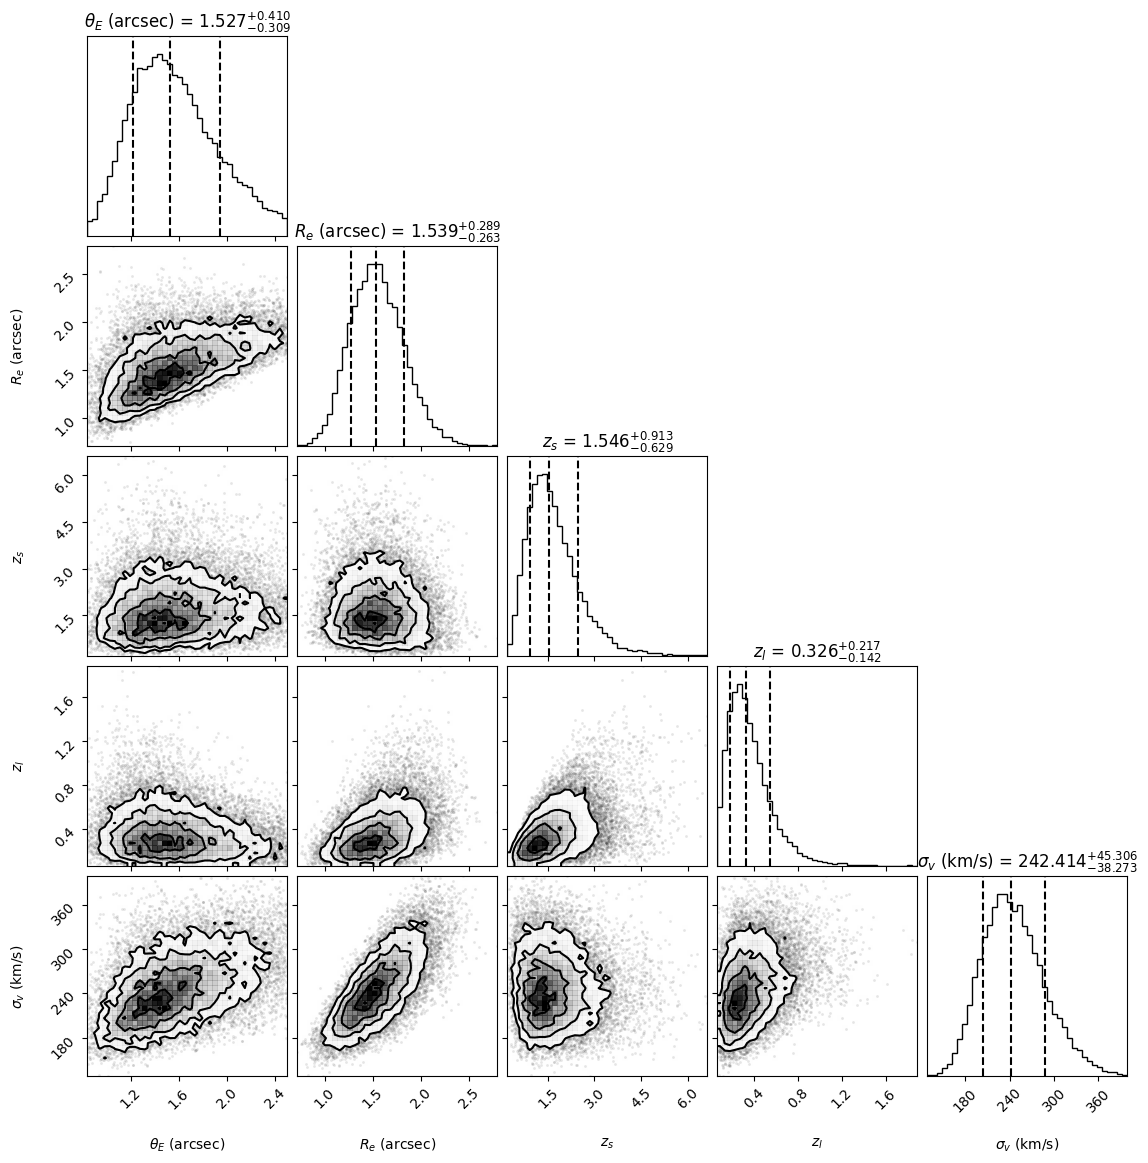

Saved: result/lens_fp_data_corner.pdf


In [17]:
# Corner plot after data preparation
import corner

samples_fp = np.column_stack([
    thetaE_obs_clean_fp,
    re_fp,
    zs_obs_clean_fp,
    zl_obs_clean_fp,
    vel_obs_clean_fp,
])

labels_fp = [
    r'$\theta_E$ (arcsec)',
    r'$R_e$ (arcsec)',
    r'$z_s$',
    r'$z_l$',
    r'$\sigma_v$ (km/s)',
]

fig = corner.corner(
    samples_fp,
    labels=labels_fp,
    bins=40,
    show_titles=True,
    title_fmt='.3f',
    quantiles=[0.16, 0.5, 0.84],
)
fig.savefig(FIG_DIR / 'lens_fp_data_corner.pdf', dpi=200, bbox_inches='tight')
plt.show()
print('Saved:', FIG_DIR / 'lens_fp_data_corner.pdf')


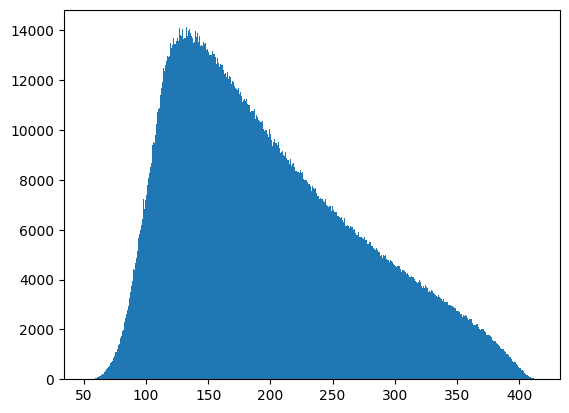

In [18]:
_ = plt.hist(LUT.flatten(), bins = 1000)

(array([5.000e+00, 1.000e+00, 1.200e+01, 1.500e+01, 2.600e+01, 6.000e+01,
        8.200e+01, 1.340e+02, 1.920e+02, 2.910e+02, 3.520e+02, 4.590e+02,
        6.200e+02, 7.270e+02, 8.860e+02, 1.039e+03, 1.118e+03, 1.240e+03,
        1.460e+03, 1.515e+03, 1.573e+03, 1.715e+03, 1.817e+03, 1.833e+03,
        1.900e+03, 1.936e+03, 2.065e+03, 2.022e+03, 1.969e+03, 1.972e+03,
        1.980e+03, 2.010e+03, 2.016e+03, 1.913e+03, 1.924e+03, 1.791e+03,
        1.742e+03, 1.767e+03, 1.720e+03, 1.614e+03, 1.613e+03, 1.597e+03,
        1.566e+03, 1.444e+03, 1.354e+03, 1.299e+03, 1.309e+03, 1.317e+03,
        1.229e+03, 1.180e+03]),
 array([0.16122837, 0.16400379, 0.1667792 , 0.16955462, 0.17233004,
        0.17510546, 0.17788088, 0.1806563 , 0.18343172, 0.18620714,
        0.18898256, 0.19175798, 0.1945334 , 0.19730882, 0.20008424,
        0.20285966, 0.20563507, 0.20841049, 0.21118591, 0.21396133,
        0.21673675, 0.21951217, 0.22228759, 0.22506301, 0.22783843,
        0.23061385, 0.23338927, 0.23

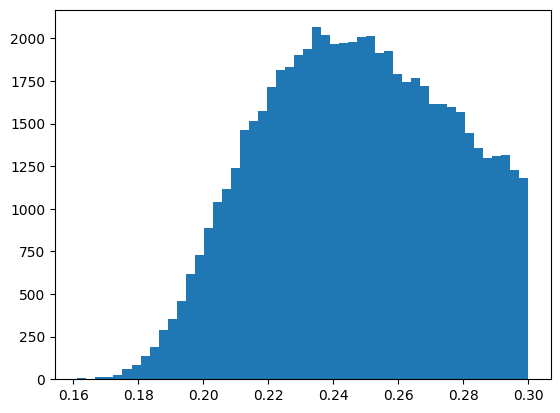

In [19]:
plt.hist(vel_frac_err_template, bins = 50)
# plt.xlim([1.5, 2.5])
# plt.ylim([0, 1000])

In [20]:
def cosmology_model(kind, cosmo_prior, sample_h0=True):
    cosmo = {
        'Omegam': numpyro.sample('Omegam', dist.Uniform(cosmo_prior['omegam_low'], cosmo_prior['omegam_up'])),
        'Omegak': 0.0,
        'w0': -1.0,
        'wa': 0.0,
        'h0': 70.0,
    }
    if kind in ['wcdm', 'owcdm', 'waw0cdm', 'owaw0cdm']:
        cosmo['w0'] = numpyro.sample('w0', dist.Uniform(cosmo_prior['w0_low'], cosmo_prior['w0_up']))
    if kind in ['waw0cdm', 'owaw0cdm']:
        cosmo['wa'] = numpyro.sample('wa', dist.Uniform(cosmo_prior['wa_low'], cosmo_prior['wa_up']))
    if kind in ['owcdm', 'owaw0cdm']:
        cosmo['Omegak'] = numpyro.sample('Omegak', dist.Uniform(cosmo_prior['omegak_low'], cosmo_prior['omegak_up']))
    if sample_h0:
        cosmo['h0'] = numpyro.sample('h0', dist.Uniform(cosmo_prior['h0_low'], cosmo_prior['h0_up']))
    return cosmo


def fundamental_plane_model(fp_data):
    cosmo = cosmology_model('waw0cdm', cosmo_prior, sample_h0=True)

    lambda_mean = numpyro.sample('lambda_mean', dist.Uniform(0.9, 1.1))
    lambda_sigma = numpyro.sample('lambda_sigma', dist.TruncatedNormal(0.05, 0.5, low=0.0, high=0.2))
    gamma_mean = numpyro.sample('gamma_mean', dist.Uniform(1.4, 2.6))
    gamma_sigma = numpyro.sample('gamma_sigma', dist.TruncatedNormal(0.2, 0.2, low=0.0, high=0.4))
    beta_mean = numpyro.sample('beta_mean', dist.Uniform(-0.3, 0.3))
    beta_sigma = numpyro.sample('beta_sigma', dist.TruncatedNormal(0.2, 0.2, low=0.0, high=0.4))

    n_lens = len(fp_data['zl'])
    with numpyro.plate('fp_redshift', n_lens):
        zL_fp = numpyro.sample(
            'zL_fp_latent',
            dist.TruncatedNormal(fp_data['zl'], fp_data['zL_err'], low=fp_data['zL_low'], high=fp_data['zL_high']),
        )
        zS_fp = numpyro.sample(
            'zS_fp_latent',
            dist.TruncatedNormal(fp_data['zs'], fp_data['zS_err'], low=fp_data['zS_low'], high=fp_data['zS_high']),
        )

    _dl, ds_fp, dls_fp = tool.dldsdls(zL_fp, zS_fp, cosmo, n=20)
    with numpyro.plate('fundamental_plane', n_lens):
        gamma_fp = numpyro.sample('gamma_fp', dist.TruncatedNormal(gamma_mean, gamma_sigma, low=1.4, high=2.6))
        beta_fp = numpyro.sample('beta_fp', dist.TruncatedNormal(beta_mean, beta_sigma, low=-0.4, high=0.4))
        lambda_fp = numpyro.sample('lambda_fp', dist.TruncatedNormal(lambda_mean, lambda_sigma, low=0.8, high=1.2))
        thetaE_fp = numpyro.sample('thetaE_fp', dist.Normal(fp_data['theta_E'], fp_data['theta_E_err']))

        v_interp_fp = jampy_interp(thetaE_fp, gamma_fp, fp_data['re'], beta_fp)
        vel_pred_fp = v_interp_fp * jnp.sqrt(ds_fp / dls_fp) * jnp.sqrt(lambda_fp)
        numpyro.sample(
            'gamma_fp_like',
            dist.Normal(gamma_fp, fp_data['gamma_err']),
            obs=fp_data['gamma_obs'],
        )
        numpyro.sample(
            'vel_fp_like',
            dist.Normal(vel_pred_fp, fp_data['vel_err']),
            obs=fp_data['vel_obs'],
        )


In [21]:
def build_init_values(fp_data):
    zl_true = np.asarray(fp_data.get('zl_true', fp_data['zl']), dtype=np.float64)
    zs_true = np.asarray(fp_data.get('zs_true', fp_data['zs']), dtype=np.float64)
    zL_low = np.asarray(fp_data.get('zL_low', fp_data['zl'] - Z_SIGMA_CLIP * fp_data['zL_err']), dtype=np.float64)
    zL_high = np.asarray(fp_data.get('zL_high', fp_data['zl'] + Z_SIGMA_CLIP * fp_data['zL_err']), dtype=np.float64)
    zS_low = np.asarray(fp_data.get('zS_low', fp_data['zs'] - Z_SIGMA_CLIP * fp_data['zS_err']), dtype=np.float64)
    zS_high = np.asarray(fp_data.get('zS_high', fp_data['zs'] + Z_SIGMA_CLIP * fp_data['zS_err']), dtype=np.float64)
    theta_true = np.asarray(fp_data.get('theta_E_true', fp_data['theta_E']), dtype=np.float64)
    gamma_true = np.asarray(fp_data.get('gamma_true', fp_data['gamma_obs']), dtype=np.float64)
    beta_true = np.asarray(fp_data.get('beta_true', np.zeros_like(theta_true)), dtype=np.float64)
    lambda_true = np.asarray(fp_data.get('lambda_true', np.ones_like(theta_true)), dtype=np.float64)

    zl_true = np.clip(zl_true, zL_low + 1e-6, zL_high - 1e-6)
    zs_true = np.clip(zs_true, zS_low + 1e-6, zS_high - 1e-6)
    theta_true = np.maximum(theta_true, 1e-3)
    gamma_true = np.clip(gamma_true, 1.401, 2.599)
    beta_true = np.clip(beta_true, -0.399, 0.399)
    lambda_true = np.clip(lambda_true, 0.801, 1.199)

    return {
        'Omegam': jnp.asarray(cosmo_true['Omegam']),
        'w0': jnp.asarray(cosmo_true['w0']),
        'wa': jnp.asarray(cosmo_true['wa']),
        'h0': jnp.asarray(cosmo_true['h0']),
        'lambda_mean': jnp.asarray(1.0),
        'lambda_sigma': jnp.asarray(0.08),
        'gamma_mean': jnp.asarray(2.0),
        'gamma_sigma': jnp.asarray(0.25),
        'beta_mean': jnp.asarray(0.0),
        'beta_sigma': jnp.asarray(0.25),
        'zL_fp_latent': jnp.asarray(zl_true),
        'zS_fp_latent': jnp.asarray(zs_true),
        'gamma_fp': jnp.asarray(gamma_true),
        'beta_fp': jnp.asarray(beta_true),
        'lambda_fp': jnp.asarray(lambda_true),
        'thetaE_fp': jnp.asarray(theta_true),
    }


def run_mcmc(data, key, tag):
    if TEST_MODE:
        num_warmup, num_samples, num_chains, chain_method = 200, 200, 2, 'sequential'
    else:
        num_warmup, num_samples, num_chains, chain_method = 500, 1500, 4, 'vectorized'

    nuts = NUTS(
        fundamental_plane_model,
        target_accept_prob=0.95,
        init_strategy=init_to_value(values=build_init_values(data)),
    )
    mcmc = MCMC(
        nuts,
        num_warmup=num_warmup,
        num_samples=num_samples,
        num_chains=num_chains,
        chain_method=chain_method,
        progress_bar=True,
    )
    mcmc.run(key, fp_data=data)
    print(f'[{tag}] run uses init_to_value')

    extra = mcmc.get_extra_fields(group_by_chain=True)
    n_div = int(np.asarray(extra['diverging']).sum())
    print(f'[{tag}] divergences: {n_div}')

    posterior = mcmc.get_samples(group_by_chain=True)
    inf_data = az.from_dict(posterior=posterior)
    az.to_netcdf(inf_data, RESULT_DIR / f'lens_fp_{tag}.nc')

    trace_vars = ['h0', 'Omegam', 'w0', 'wa', 'lambda_mean', 'lambda_sigma', 'gamma_mean', 'gamma_sigma', 'beta_mean', 'beta_sigma']
    trace_vars = [v for v in trace_vars if v in inf_data.posterior and inf_data.posterior[v].ndim == 2]
    if trace_vars:
        trace_axes = az.plot_trace(inf_data, var_names=trace_vars, compact=False)
        trace_fig = np.asarray(trace_axes).ravel()[0].figure
        trace_fig.savefig(FIG_DIR / f'lens_fp_trace_{tag}.pdf', dpi=200, bbox_inches='tight')
        plt.close(trace_fig)
    return inf_data


key = random.PRNGKey(42)
key_clean, key_noisy = random.split(key)

idata_clean = run_mcmc(fp_data_clean, key_clean, 'clean')
# idata_noisy = run_mcmc(fp_data_noisy, key_noisy, 'noisy')


sample: 100%|██████████| 2000/2000 [08:29<00:00,  3.93it/s]


[clean] run uses init_to_value
[clean] divergences: 0


In [8]:
corner_vars = select_corner_vars(
    idata_clean,
    idata_noisy,
    ['h0', 'Omegam', 'w0', 'wa', 'lambda_mean', 'lambda_sigma', 'gamma_mean', 'gamma_sigma', 'beta_mean', 'beta_sigma'],
)
make_overlay_corner(idata_clean, idata_noisy, corner_vars, FIG_DIR / 'lens_fp_corner_overlay.pdf')

print('Saved:')
print(RESULT_DIR / 'lens_fp_clean.nc')
print(RESULT_DIR / 'lens_fp_noisy.nc')
print(FIG_DIR / 'lens_fp_trace_clean.pdf')
print(FIG_DIR / 'lens_fp_trace_noisy.pdf')
print(FIG_DIR / 'lens_fp_corner_overlay.pdf')

Saved:
/mnt/lustre/tianli/LensedUniverse_result/lens_fp_clean.nc
/mnt/lustre/tianli/LensedUniverse_result/lens_fp_noisy.nc
result/lens_fp_trace_clean.pdf
result/lens_fp_trace_noisy.pdf
result/lens_fp_corner_overlay.pdf


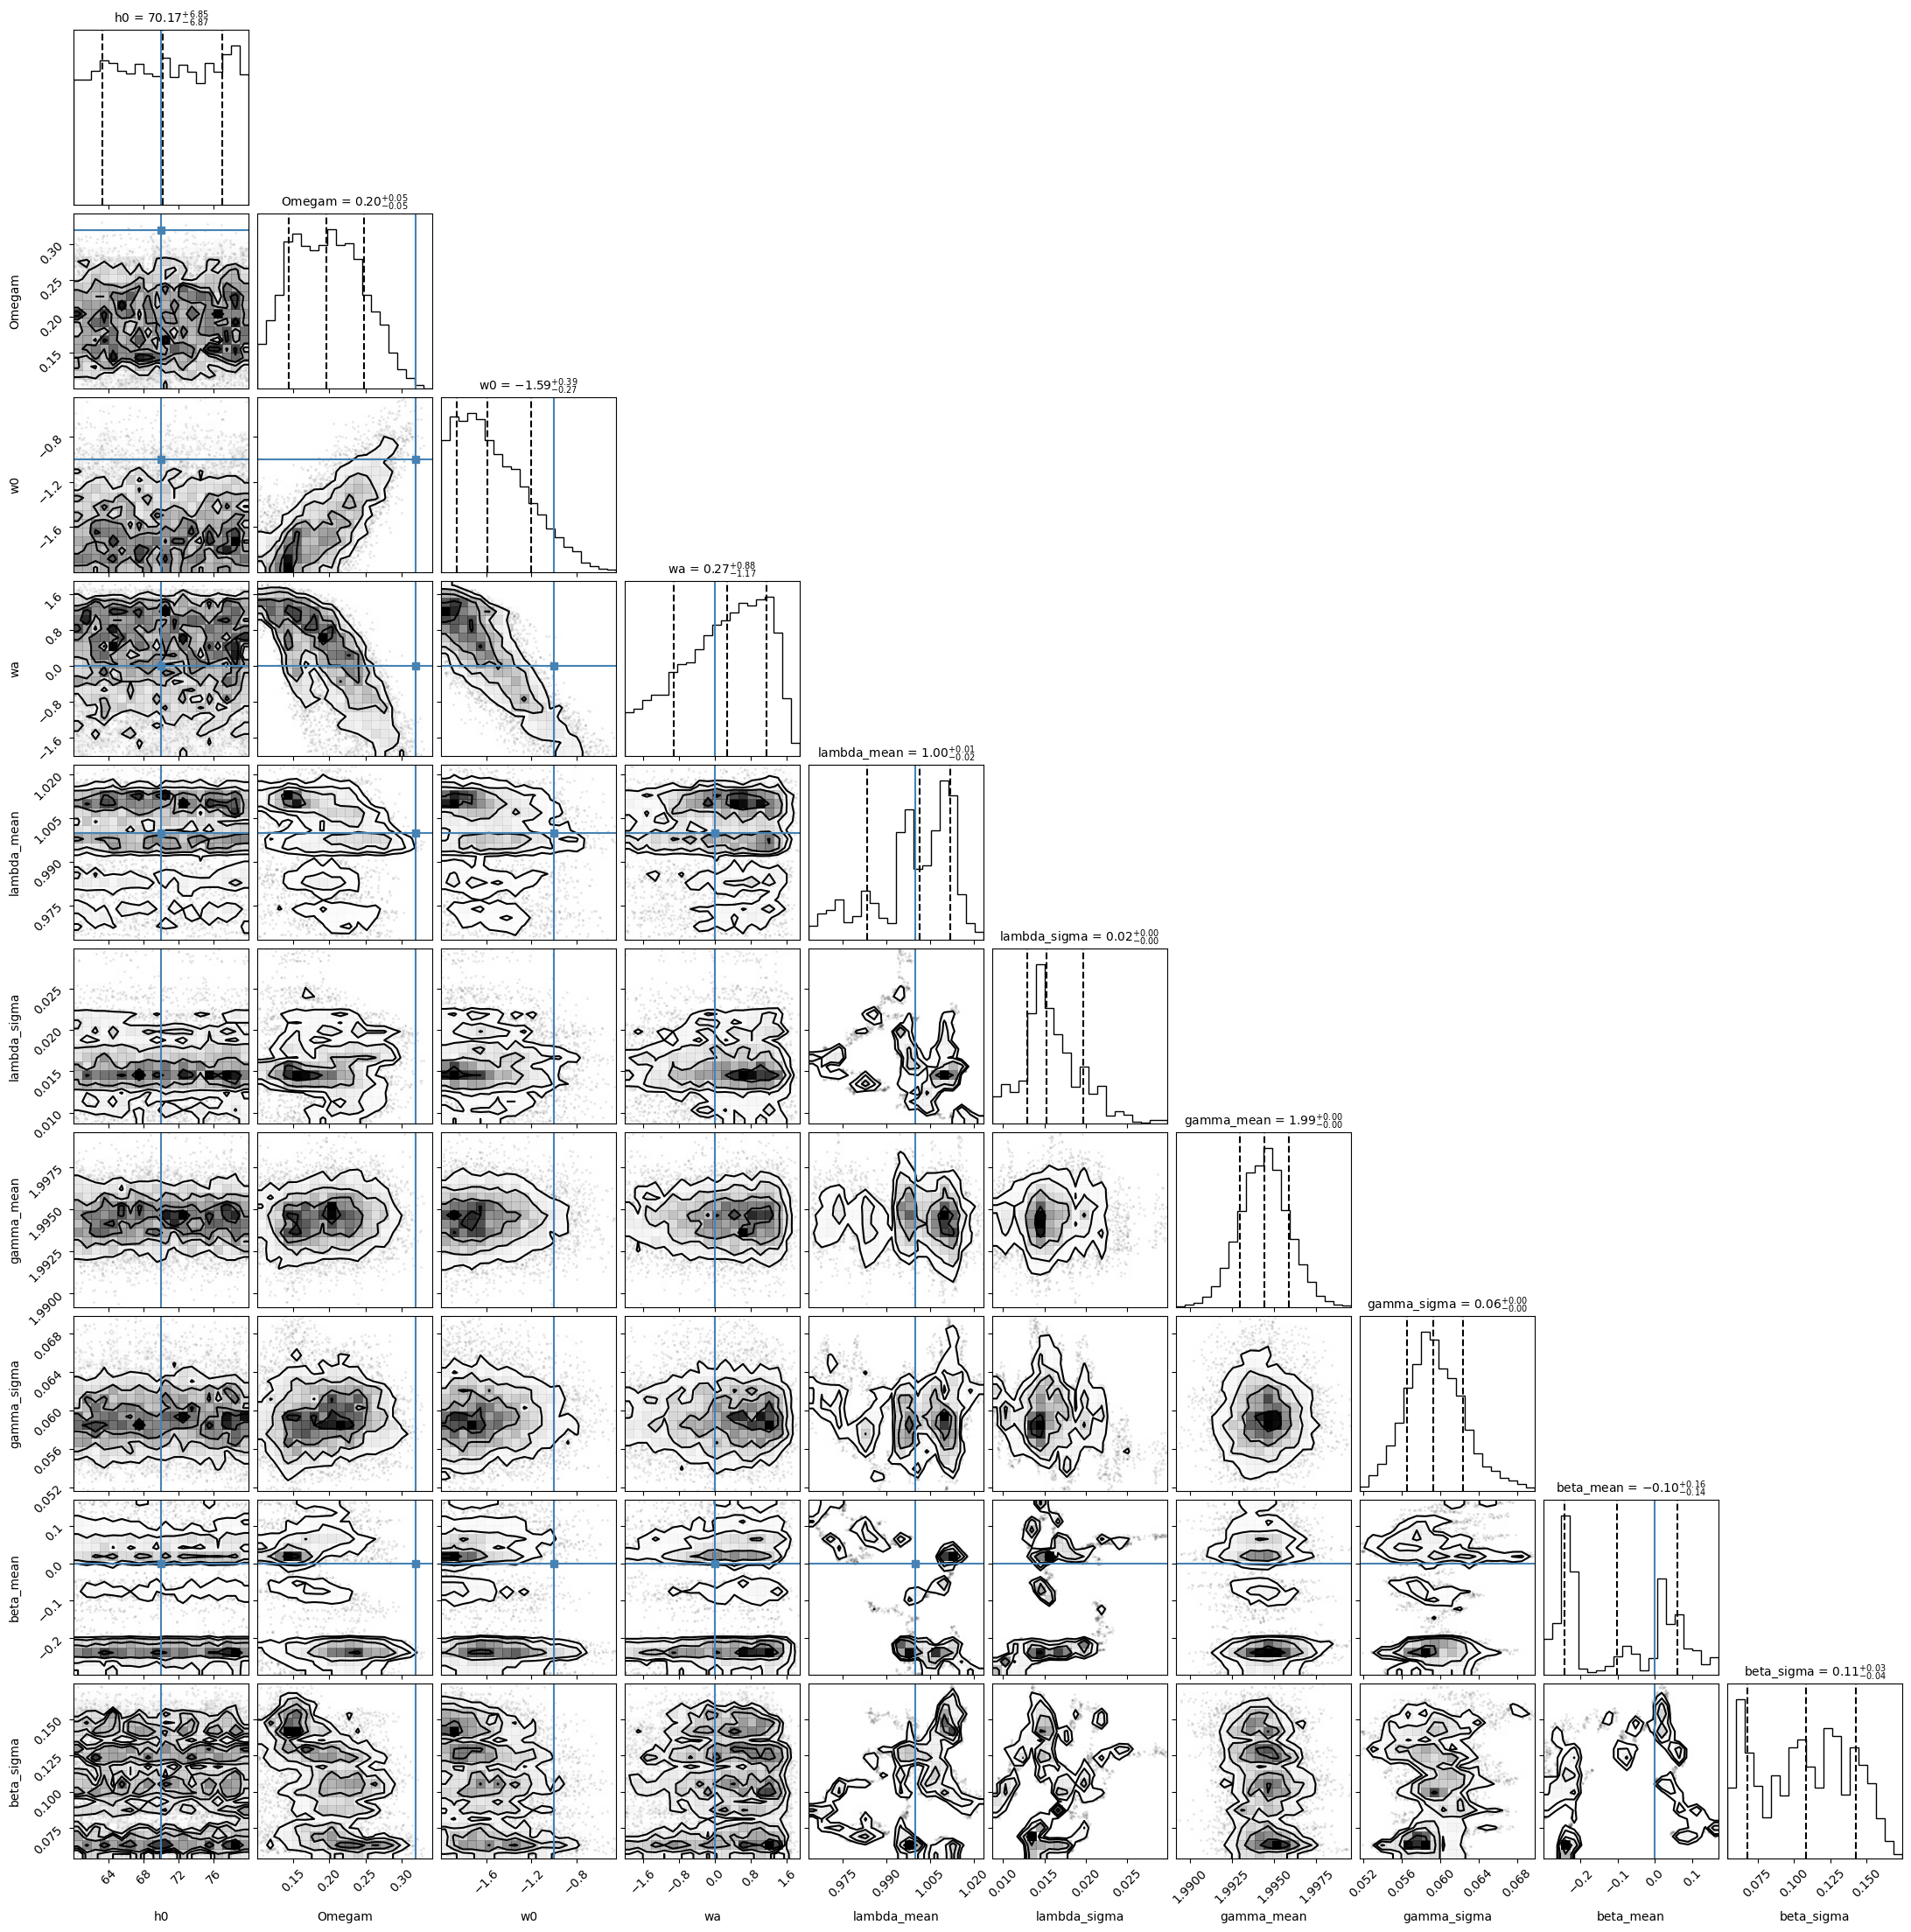

In [22]:
import arviz as az
import numpy as np
import corner
import matplotlib.pyplot as plt

path = "/mnt/lustre/tianli/LensedUniverse_result/lens_fp_clean.nc"
idata = az.from_netcdf(path)

vars_ = ['h0', 'Omegam', 'w0', 'wa',
         'lambda_mean', 'lambda_sigma',
         'gamma_mean', 'gamma_sigma',
         'beta_mean', 'beta_sigma']

post = idata.posterior
missing = [v for v in vars_ if v not in post.data_vars]
if missing:
    raise KeyError(f"Missing in idata.posterior: {missing}\nAvailable: {list(post.data_vars)}")

# --- truths: fill these with your ground-truth / injected values ---
truth_dict = {
    'h0': 70, 'Omegam': 0.32, 'w0': -1, 'wa': 0,
    'lambda_mean': 1, 'lambda_sigma': 0.05,
    'gamma_mean': 2, 'gamma_sigma': 0.2,
    'beta_mean': 0, 'beta_sigma': 0.5,
}
truths = [truth_dict[v] for v in vars_]  # order must match vars_

# stack chains/draws -> (nsamples, nvars)
samples = np.column_stack([
    np.asarray(post[v].stack(sample=("chain", "draw")).values).reshape(-1)
    for v in vars_
])

fig = corner.corner(
    samples,
    labels=vars_,
    truths=truths,                 # <- adds truth lines/markers
    show_titles=True,
    title_kwargs={"fontsize": 10},
    quantiles=[0.16, 0.5, 0.84],
)
plt.show()
